/home/qy/software/anaconda3/envs/gluon/lib/python3.6/site-packages/mxnet/recordio.py:370: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  header = header._replace(label=np.fromstring(s, np.float32, header.flag))


DataBatch: data shapes: [(32, 3, 256, 256)] label shapes: [(32, 1, 5)]
(1, 3, 256, 256)

[[ 0.          0.6337336   0.09517132  0.4164515   0.25929707  0.6608266 ]
 [ 0.          0.6276029   0.40521938  0.42220128  0.6140433   0.7022898 ]
 [-1.          0.60243845  0.09184695  0.43256217  0.30487546  0.704781  ]
 [ 0.          0.598556    0.06077033  0.20080139  0.23408502  0.41945302]
 [ 0.          0.5817347   0.2931554   0.2630278   0.43930414  0.5056321 ]
 [-1.          0.53474945  0.11063086  0.4262441   0.2776322   0.6868514 ]
 [ 0.          0.5346367   0.6199095   0.22232957  0.76834416  0.50345594]
 [ 0.          0.53002626  0.7436758   0.43619734  0.9199196   0.70006055]
 [-1.          0.5282933   0.7468314   0.47016847  0.90971005  0.7037443 ]
 [-1.          0.5111046   0.6109292   0.23628788  0.778186    0.46864676]
 [ 0.          0.5040759   0.22642899  0.39759594  0.59670854  0.748411  ]
 [-1.          0.49479467  0.10122155  0.42209634  0.2542601   0.6448207 ]
 [-1.      

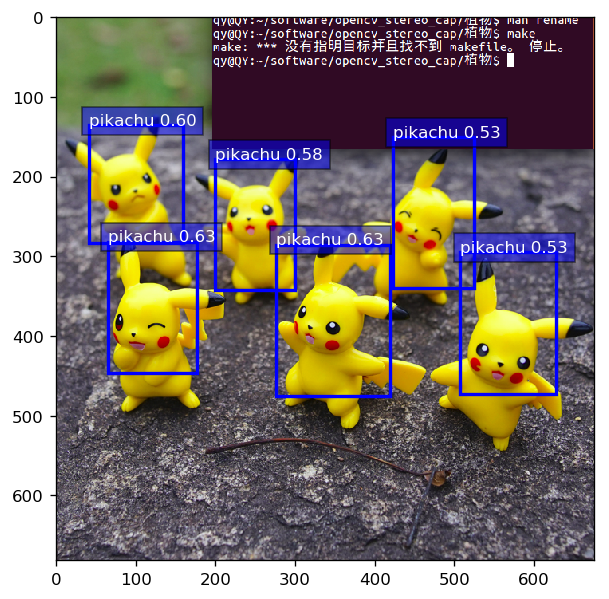

In [5]:
from mxnet import gluon
import mxnet as mx
import os
import numpy as np 
ctx = mx.cpu()
root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/'
            'gluon/dataset/pikachu/')
data_dir = '../data/pikachu/'
dataset = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
          'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
          'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}
from mxnet import image
from mxnet import nd
data_shape = 256
batch_size = 32
rgb_mean = nd.array([123, 117, 104])
def get_iterators(data_shape, batch_size):
    class_names = ['pikachu'] #类名称
    num_class = len(class_names)#类的个数
    train_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),#3*256*256
        path_imgrec=data_dir+'train.rec',
        path_imgidx=data_dir+'train.idx',
        shuffle=True,
        mean=True,
        rand_crop=1,
        min_object_covered=0.95,
        max_attempts=200)
    val_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec=data_dir+'val.rec',
        shuffle=False,
        mean=True)
    return train_iter, val_iter, class_names, num_class

train_data, test_data, class_names, num_class = get_iterators(
    data_shape, batch_size)

batch = train_data.next()
print(batch)
print((batch.data[0][0:1]).shape)


%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

def box_to_rect(box, color, linewidth=3):
    """convert an anchor box to a matplotlib rectangle"""
    box = box.asnumpy()
    return plt.Rectangle(
        (box[0], box[1]), box[2]-box[0], box[3]-box[1],
        fill=False, edgecolor=color, linewidth=linewidth)

from mxnet import nd
from mxnet.contrib.ndarray import MultiBoxPrior

#预测物体的类别
from mxnet.gluon import nn
def class_predictor(num_anchors, num_classes):
    """return a layer to predict classes"""
    return nn.Conv2D(num_anchors * (num_classes + 1), 3, padding=1)

#预测物体的边框
def box_predictor(num_anchors):
    """return a layer to predict delta locations"""
    return nn.Conv2D(num_anchors * 4, 3, padding=1)

#减半模块
def down_sample(num_filters):
    """stack two Conv-BatchNorm-Relu blocks and then a pooling layer
    to halve the feature size"""
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filters, 3, strides=1, padding=1))#输出　num_filters　个通道数
        out.add(nn.BatchNorm(in_channels=num_filters))#归一化
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2)) 
    return out

#将不同层的输出合并
def flatten_prediction(pred):
    return pred.transpose(axes=(0,2,3,1)).flatten()

def concat_predictions(preds):
    return nd.concat(*preds, dim=1)

#主体网络
def body():
    out = nn.HybridSequential()
    for nfilters in [16, 32, 64]:
        out.add(down_sample(nfilters))
    return out

#定义ssd模型
def toy_ssd_model(num_anchors, num_classes):
    downsamplers = nn.Sequential()
    for _ in range(3):
        downsamplers.add(down_sample(128))
        
    class_predictors = nn.Sequential()
    box_predictors = nn.Sequential()    
    for _ in range(5):
        class_predictors.add(class_predictor(num_anchors, num_classes))
        box_predictors.add(box_predictor(num_anchors))

    model = nn.Sequential()
    model.add(body(), downsamplers, class_predictors, box_predictors)
    return model

#计算预测

def toy_ssd_forward(x, model, sizes, ratios, verbose=False):    
    body, downsamplers, class_predictors, box_predictors = model
    anchors, class_preds, box_preds = [], [], []
    # feature extraction    
    x = body(x)#feature extraction完毕
    for i in range(5):
        # predict
        anchors.append(MultiBoxPrior(
            x, sizes=sizes[i], ratios=ratios[i]))
        class_preds.append(
            flatten_prediction(class_predictors[i](x)))
        box_preds.append(
            flatten_prediction(box_predictors[i](x)))
        if verbose:
            print('Predict scale', i, x.shape, 'with', 
                  anchors[-1].shape[1], 'anchors')
        # down sample
        if i < 3:
            x = downsamplers[i](x)
        elif i == 3:
            x = nd.Pooling(
                x, global_pool=True, pool_type='max', 
                kernel=(x.shape[2], x.shape[3]))
    # concat data
    return (concat_predictions(anchors),
            concat_predictions(class_preds),
            concat_predictions(box_preds))

#完整的模型
from mxnet import gluon
class ToySSD(gluon.Block):
    def __init__(self, num_classes, verbose=False, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        # anchor box sizes and ratios for 5 feature scales
        self.sizes = [[.2,.272], [.37,.447], [.54,.619], 
                      [.71,.79], [.88,.961]]
        self.ratios = [[1,2,.5]]*5
        self.num_classes = num_classes
        self.verbose = verbose
        num_anchors = len(self.sizes[0]) + len(self.ratios[0]) - 1
        # use name_scope to guard the names
        with self.name_scope():
            self.model = toy_ssd_model(num_anchors, num_classes)

    def forward(self, x):
        anchors, class_preds, box_preds = toy_ssd_forward(
            x, self.model, self.sizes, self.ratios, 
            verbose=self.verbose)
        # it is better to have class predictions reshaped for softmax computation       
        class_preds = class_preds.reshape(shape=(0, -1, self.num_classes+1))
        return anchors, class_preds, box_preds
    
#预测初始化
from mxnet import init
from mxnet import cpu
import os
os.makedirs('checkpoints',exist_ok=True)
filename = "checkpoints/testnet.params"
filename_2 = "checkpoints_2/ssd_net.params"
filename_3 = "checkpoints_3/ssd_net_3.params"
ctx = cpu(0)
#train_data.reshape(label_shape=(3, 5))
#train_data = test_data.sync_label_shape(train_data)
net = ToySSD(num_class)
net.load_params(filename_3, ctx=ctx)

#图像预处理
def process_image(fname):
    with open(fname, 'rb') as f:
        im = image.imdecode(f.read())
    # resize to data_shape
    data = image.imresize(im, data_shape, data_shape)
    # minus rgb mean
    data = data.astype('float32') - rgb_mean
    # convert to batch x channel x height xwidth
    return data.transpose((2,0,1)).expand_dims(axis=0), im

#定义预测函数
from mxnet.contrib.ndarray import MultiBoxDetection

def predict(x):
    anchors, cls_preds, box_preds = net(x.as_in_context(ctx))
    cls_probs = nd.SoftmaxActivation(
        cls_preds.transpose((0,2,1)), mode='channel')

    return MultiBoxDetection(cls_probs, box_preds, anchors,force_suppress=True, clip=False)

#预测
path='../img/pikachu6_2.png'
path_2='../img/pikachu6.jpg'#经过旋转后的识别效果不如上图的好
path_3='../img/pikachu2.jpg'
x, im = process_image(path)
out = predict(x)
out.shape
print(out[0][0:20])

#显示输出
colors = ['blue', 'green', 'red', 'black', 'magenta']
mpl.rcParams['figure.figsize'] = (6,6)

def display(im, out, threshold=0.5):    
    plt.imshow(im.asnumpy())
    for row in out:
        row = row.asnumpy()
        class_id, score = int(row[0]), row[1]
        if class_id < 0 or score < threshold:
            continue
        color = colors[class_id%len(colors)]#例如０％５＝０　１％５＝１　２％５＝２
        box = row[2:6] * np.array([im.shape[0],im.shape[1]]*2)
        rect = box_to_rect(nd.array(box), color, 2)
        plt.gca().add_patch(rect)
                        
        text = class_names[class_id]
        plt.gca().text(box[0], box[1], 
                       '{:s} {:.2f}'.format(text, score),
                       bbox=dict(facecolor=color, alpha=0.5),
                       fontsize=10, color='white')
    plt.show()

display(im, out[0], threshold=0.51)


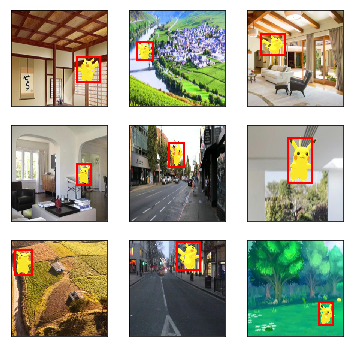

In [2]:
_, figs = plt.subplots(3, 3, figsize=(6,6))
for i in range(3):
    for j in range(3):        
        img, labels = batch.data[0][3*i+j], batch.label[0][3*i+j]
        # (3L, 256L, 256L) => (256L, 256L, 3L)
        img = img.transpose((1, 2, 0)) + rgb_mean
        img = img.clip(0,255).asnumpy()/255
        fig = figs[i][j]
        fig.imshow(img)
        for label in labels:
            rect = box_to_rect(label[1:5]*data_shape,'red',2)
            fig.add_patch(rect)                    
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
plt.show()

In [4]:
n = 40
x = nd.random.uniform(shape=(1, 3, n, n))

y = MultiBoxPrior(x, sizes=[.5,.25,.1], ratios=[1,2,.5])

boxes = y.reshape((n, n, -1, 4))
print(boxes.shape)
# The first anchor box centered on (20, 20)
# its format is (x_min, y_min, x_max, y_max)
boxes[20, 20, 0, :]

(40, 40, 5, 4)



[0.2625 0.2625 0.7625 0.7625]
<NDArray 4 @cpu(0)>